# SNSCRAPE

## tokenizer, stemmer, stopwords

In [69]:
import pandas as pd
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer

In [70]:
media_results_csv = pd.read_csv('processed twitter data/media_results.csv')
creator_results_csv = pd.read_csv('processed twitter data/creator_results.csv')
general_results_csv = pd.read_csv('processed twitter data/general_results.csv')
vogue_results_csv = pd.read_csv('processed twitter data/vogue_results.csv')
compiler_results_csv = pd.read_csv('processed twitter data/compiler_results.csv')

In [12]:
media_results_csv

,Tweet,Processed
0,Metaverse launches have been frequent in the l...,launches frequent brands including gucci adida...
1,Metaverse launches have been frequent in the l...,launches frequent brands like launching accord...
2,Positioned as a physical metaverse influencer ...,positioned physical influencer creator hub 1 2...
3,"Marketers discussed ways into the metaverse, a...",marketers discussed ways among topics digiday ...
4,Positioned as a physical metaverse influencer ...,positioned physical influencer creator hub 1 2...
...,...,...
1034,Poly Auction Hong Kong is joining hands with d...,poly auction hong kong joining hands digital a...
1035,The Hong Kong director celebrates the 30th ann...,hong kong director celebrates 30th anniversary...
1036,Poly Auction Hong Kong is joining hands with d...,poly auction hong kong joining hands digital a...
1037,The Hong Kong director celebrates the 30th ann...,hong kong director celebrates 30th anniversary...


In [13]:
new_all_df = pd.concat([media_results_csv,creator_results_csv],ignore_index = True)

In [14]:
new_all_df

,Tweet,Processed
0,Metaverse launches have been frequent in the l...,launches frequent brands including gucci adida...
1,Metaverse launches have been frequent in the l...,launches frequent brands like launching accord...
2,Positioned as a physical metaverse influencer ...,positioned physical influencer creator hub 1 2...
3,"Marketers discussed ways into the metaverse, a...",marketers discussed ways among topics digiday ...
4,Positioned as a physical metaverse influencer ...,positioned physical influencer creator hub 1 2...
...,...,...
4383,@AB_solo You can try again tomorrow… or the ne...,try tomorrow next drops continue 12 24
4384,@KaddouraHoussam The made-to-order Rogue bag i...,made order rogue bag available us owners
4385,@Thatjpeg_ Our first NFT will be available at ...,available 12 p est get ready
4386,@uuuulllii We’re offering a limited quantity o...,offering limited quantity followers free dec 1...


In [71]:
media_results_list = media_results_csv['Processed'].tolist()
creator_results_list = creator_results_csv['Processed'].tolist()
general_results_list = general_results_csv['Processed'].tolist()
vogue_results_list = vogue_results_csv['Processed'].tolist()
compiler_results_list = compiler_results_csv['Processed'].tolist()

In [47]:
all_list = media_results_list + creator_results_list
len(all_list)

4388

In [72]:
tokenizer = RegexpTokenizer(r'\w+')

all_words = []
new_all_list = []

media_words = []
creator_words = []
general_words = []
compiler_words = []
vogue_words = []

new_creator_list = []
new_general_list = []

In [49]:
idx = []

for i in range(len(all_list)):
    if type(all_list[i]) == type("string"):
        tokens = tokenizer.tokenize(all_list[i])
        all_words.append(tokens)
        new_all_list.append(all_list[i])
    else:
        print(type(all_list[i]))
        print(all_list[i])
        idx.append(i)

<class 'float'>
nan
<class 'float'>
nan
<class 'float'>
nan
<class 'float'>
nan
<class 'float'>
nan
<class 'float'>
nan


In [50]:
idx

[3300, 3517, 3519, 3592, 3694, 3783]

In [20]:
new_all_df.drop(idx, inplace = True)

In [21]:
new_all_df.reset_index(inplace = True,drop=True)

In [22]:
new_all_df

,Tweet,Processed
0,Metaverse launches have been frequent in the l...,launches frequent brands including gucci adida...
1,Metaverse launches have been frequent in the l...,launches frequent brands like launching accord...
2,Positioned as a physical metaverse influencer ...,positioned physical influencer creator hub 1 2...
3,"Marketers discussed ways into the metaverse, a...",marketers discussed ways among topics digiday ...
4,Positioned as a physical metaverse influencer ...,positioned physical influencer creator hub 1 2...
...,...,...
4377,@AB_solo You can try again tomorrow… or the ne...,try tomorrow next drops continue 12 24
4378,@KaddouraHoussam The made-to-order Rogue bag i...,made order rogue bag available us owners
4379,@Thatjpeg_ Our first NFT will be available at ...,available 12 p est get ready
4380,@uuuulllii We’re offering a limited quantity o...,offering limited quantity followers free dec 1...


In [51]:
len(all_words)

4382

In [52]:
len(new_all_list)

4382

In [53]:
new_all_list

['launches frequent brands including gucci adidas launching according new data retail consumers across uk us still unaware applications benefits',
 'launches frequent brands like launching according new data consumers uk us still unaware applications benefits story',
 'positioned physical influencer creator hub 1 2 million square foot emcee studio opening downtown l later part emcees expansion',
 'marketers discussed ways among topics digiday medias cmo summit',
 'positioned physical influencer creator hub 1 2 million square foot emcee studio opening downtown l later part emcees expansion story',
 'latest hire styling track record daphne guinness story',
 'delving skin market collection marries utility luxury design move suggests could become go path industry veterans story',
 'january dtc underwear brand meundies posted twitter joined collection bored ape yacht club reaction company received less positive story',
 'complete influencers product launches branded beauty event come story'

In [73]:
stopwords_LDA = ["go","m","pm","look","soon","start","let","yet","full","still","good","know","much", "well", 
                 "wait","try","thank","dm","lol","hit","put","ve","send","give","going","dude","stuff","get","got","l","p","10",
                 "co","gm","b","haha","work","many","hard","thing","make","next","come","fam","even","gt","1","2","3","4","5","6","7","8","9","pst",
                 "cet","est","wont","irl","100","u","x","via","hey","w","utc","worldhealthday2021","0","may","000","00","12","yes","30","24","et","1155",
                "50","20","im","15","e","7pm","vs","6pm","28","z","3pm","721","12pm","2nd","16","11","13","af","oh","17","thats","rt","30pm","8pm","21",
                 "theres","11am","17th","26","5pm","lp","youll","check","like","today","part","ever","need","every","lets","already","twitter",
                 "use","sure","something","please","tomorrow","us","see","across","pode","matic","way","fine","stay","nhs","within","might","10th",
                 "wanna","18","101","etc","per","says","came","sorry","thanks","including","another","set","able","back","left","become","gonna",
                 "comes","tonight","end","must","done","true","working","guys","never","seen","else","actually","retweet","really","200","23",
                "whose","ways","goo","led","appears","lil","till","wow","tweet","week","get","hope"]

In [55]:
for i in all_words:
    for j in i:
        if j in stopwords_LDA:
            i.remove(j)
print("done")

done


In [56]:
len(all_words)

4382

In [204]:
new_all_df['tokenized'] = all_words

In [205]:
new_all_df

,Tweet,Processed,tokenized
0,Metaverse launches have been frequent in the l...,launches frequent brands including gucci adida...,"[launches, frequent, brands, gucci, adidas, la..."
1,Metaverse launches have been frequent in the l...,launches frequent brands like launching accord...,"[launches, frequent, brands, launching, accord..."
2,Positioned as a physical metaverse influencer ...,positioned physical influencer creator hub 1 2...,"[positioned, physical, influencer, creator, hu..."
3,"Marketers discussed ways into the metaverse, a...",marketers discussed ways among topics digiday ...,"[marketers, discussed, among, topics, digiday,..."
4,Positioned as a physical metaverse influencer ...,positioned physical influencer creator hub 1 2...,"[positioned, physical, influencer, creator, hu..."
...,...,...,...
4377,@AB_solo You can try again tomorrow… or the ne...,try tomorrow next drops continue 12 24,"[tomorrow, drops, continue, 24]"
4378,@KaddouraHoussam The made-to-order Rogue bag i...,made order rogue bag available us owners,"[made, order, rogue, bag, available, owners]"
4379,@Thatjpeg_ Our first NFT will be available at ...,available 12 p est get ready,"[available, p, get, ready]"
4380,@uuuulllii We’re offering a limited quantity o...,offering limited quantity followers free dec 1...,"[offering, limited, quantity, followers, free,..."


In [206]:
new_all_df.to_csv('new_all_df.csv', index=False)

In [77]:
for tweet_text in media_results_list:
    if type(tweet_text) == type("string"):
        tokens = tokenizer.tokenize(tweet_text)
        media_words.append(tokens)
    else:
        print(type(tweet_text))
        media_results_list.remove(tweet_text)

In [78]:
len(media_words)

1039

In [79]:
len(media_results_list)

1039

In [80]:
for tweet_text in creator_results_list:
    if type(tweet_text) == type("string"):
        tokens = tokenizer.tokenize(tweet_text)
        creator_words.append(tokens)
        new_creator_list.append(tweet_text)
    else:
        print(type(tweet_text))
        print(tweet_text)

<class 'float'>
nan
<class 'float'>
nan
<class 'float'>
nan
<class 'float'>
nan
<class 'float'>
nan
<class 'float'>
nan


In [81]:
len(creator_words)

3343

In [82]:
len(new_creator_list)

3343

In [83]:
new_creator_list

['inspired profound desire explore new playgrounds vault recently chose acquire parcels land sandbox voxel voxel bespoke world become eclectic space fostering boundary pushing creativity',
 'vault aims embrace web3 delving deep creation nonfungible tokens lining shelves physical digital assets different eras ideas hybridize create perfect conditions spark new creativity future',
 'preview roadmap supergucci vault part part drop beginning february 1st featuring 10 exclusive accompanied ceramic sculpture handmade italy co designed gucci guccivault',
 'gm house delighted announce launch experimental space vault place foster open conversations community next join guccivault',
 'welcome fren 2022 see guccivault',
 'transcending confines time space ten supergucci created house represent visionary path experimentation discover drop alessandromichele guccivault',
 'stepping new dimension guccivault supergucci launch synthetic celebrities enter space gucci past present future co exist discover 

In [207]:
idx = []
new_general_list = []
general_words = []

for i in range(len(general_results_list)):
    if type(general_results_list[i]) == type("string"):
        tokens = tokenizer.tokenize(general_results_list[i])
        general_words.append(tokens)
        new_general_list.append(general_results_list[i])
    else:
        print(type(general_results_list[i]))
        print(general_results_list[i])
        idx.append(i)


<class 'float'>
nan
<class 'float'>
nan
<class 'float'>
nan
<class 'float'>
nan
<class 'float'>
nan
<class 'float'>
nan
<class 'float'>
nan
<class 'float'>
nan
<class 'float'>
nan
<class 'float'>
nan
<class 'float'>
nan
<class 'float'>
nan
<class 'float'>
nan
<class 'float'>
nan
<class 'float'>
nan
<class 'float'>
nan
<class 'float'>
nan
<class 'float'>
nan
<class 'float'>
nan
<class 'float'>
nan
<class 'float'>
nan
<class 'float'>
nan
<class 'float'>
nan
<class 'float'>
nan
<class 'float'>
nan
<class 'float'>
nan
<class 'float'>
nan
<class 'float'>
nan
<class 'float'>
nan
<class 'float'>
nan
<class 'float'>
nan
<class 'float'>
nan
<class 'float'>
nan
<class 'float'>
nan
<class 'float'>
nan
<class 'float'>
nan
<class 'float'>
nan
<class 'float'>
nan
<class 'float'>
nan
<class 'float'>
nan
<class 'float'>
nan
<class 'float'>
nan
<class 'float'>
nan
<class 'float'>
nan
<class 'float'>
nan
<class 'float'>
nan
<class 'float'>
nan
<class 'float'>
nan
<class 'float'>
nan
<class 'float'>
nan


In [208]:
len(general_words)

24944

In [209]:
len(new_general_list)

24944

In [210]:
general_results_csv

,Tweet,Processed
0,“Digital fashion and virtual spaces are expand...,digital virtual spaces expanding beyond games ...
1,⚡Shiba Inu To Launch New NFT Fashion Collectio...,shiba inu launch new collection british design...
2,Decentraland to Host Metaverse Fashion Week Wi...,decentraland host week tommy hilfiger dolce ga...
3,Set a reminder for my upcoming Space!\nLearn a...,set reminder upcoming space learn speak dev te...
4,HAPPENING NOW! 🔥\n\n“HYPE NFT” drop series by ...,happening hype drop series contemporary illust...
...,...,...
24997,Brands are entering the metaverse through virt...,brands entering virtual stores ar gaming digit...
24998,@8sianNFT i wonder how #8sian will represent t...,wonder 8sian represent style within collection...
24999,How #fashion brands are navigating #NFTs and w...,brands navigating next fashionblog burberry do...
25000,MYAMI preview 🔇🔈\n\nThe future of e-commerce w...,myami preview future e commerce longer exist 2...


In [211]:
general_results_csv.drop(idx,inplace = True)

In [213]:
general_results_csv['tokenized'] = general_words

In [214]:
general_results_csv

,Tweet,Processed,tokenized
0,“Digital fashion and virtual spaces are expand...,digital virtual spaces expanding beyond games ...,"[digital, virtual, spaces, expanding, beyond, ..."
1,⚡Shiba Inu To Launch New NFT Fashion Collectio...,shiba inu launch new collection british design...,"[shiba, inu, launch, new, collection, british,..."
2,Decentraland to Host Metaverse Fashion Week Wi...,decentraland host week tommy hilfiger dolce ga...,"[decentraland, host, week, tommy, hilfiger, do..."
3,Set a reminder for my upcoming Space!\nLearn a...,set reminder upcoming space learn speak dev te...,"[set, reminder, upcoming, space, learn, speak,..."
4,HAPPENING NOW! 🔥\n\n“HYPE NFT” drop series by ...,happening hype drop series contemporary illust...,"[happening, hype, drop, series, contemporary, ..."
...,...,...,...
24997,Brands are entering the metaverse through virt...,brands entering virtual stores ar gaming digit...,"[brands, entering, virtual, stores, ar, gaming..."
24998,@8sianNFT i wonder how #8sian will represent t...,wonder 8sian represent style within collection...,"[wonder, 8sian, represent, style, within, coll..."
24999,How #fashion brands are navigating #NFTs and w...,brands navigating next fashionblog burberry do...,"[brands, navigating, next, fashionblog, burber..."
25000,MYAMI preview 🔇🔈\n\nThe future of e-commerce w...,myami preview future e commerce longer exist 2...,"[myami, preview, future, e, commerce, longer, ..."


In [215]:
general_results_csv.to_csv('new_general_df.csv', index=False)

In [242]:
len(general_results_list)

25002

In [243]:
new_general_list

['digital virtual spaces expanding beyond games roblox identify gaming platform upcoming week many brands selling digital physical versions designs gucci adidas ar',
 'shiba inu launch new collection british designer john richmond shib shibarmy cryptocurrency cryptonews crypto',
 'decentraland host week tommy hilfiger dolce gabbana selfridges blockchain based virtual world decentraland announced launch week scheduled take place march 24 27 2022',
 'set reminder upcoming space learn speak dev team spaceshost twitterspaces womeninnfts dressmaking',
 'happening hype drop series contemporary illustrator fran ois berthoud collaboration x mad xr x foundation sozzani accepting offers',
 'apien join biggest movement today 8pm est discuss ways take apiens next level makes us different special',
 'learning wearable partnerships web3',
 'retail playing role seen rebecca minkoff launching collection new york week dolce gabbana r l surprised world dropped generating 5m sales',
 'week brands display

In [74]:
for tweet_text in compiler_results_list:
    if type(tweet_text) == type("string"):
        tokens = tokenizer.tokenize(tweet_text)
        compiler_words.append(tokens)
    else:
        print(type(tweet_text))
        compiler_results_list.remove(tweet_text)

In [219]:
for tweet_text in vogue_results_list:
    if type(tweet_text) == type("string"):
        tokens = tokenizer.tokenize(tweet_text)
        vogue_words.append(tokens)
    else:
        print(type(tweet_text))
        vogue_results_list.remove(tweet_text)

In [28]:
stopwords_LDA = ["go","m","pm","look","soon","start","let","yet","full","still","good","know","much", "well", 
                 "wait","try","thank","dm","lol","hit","put","ve","send","give","going","dude","stuff","get","got","l","p","10",
                 "co","gm","b","haha","work","many","hard","thing","make","next","come","fam","even","gt","1","2","3","4","5","6","7","8","9","pst",
                 "cet","est","wont","irl","100","u","x","via","hey","w","utc","worldhealthday2021","0","may","000","00","12","yes","30","24","et","1155",
                "50","20","im","15","e","7pm","vs","6pm","28","z","3pm","721","12pm","2nd","16","11","13","af","oh","17","thats","rt","30pm","8pm","21",
                 "theres","11am","17th","26","5pm","lp","youll","check","like","today","part","ever","need","every","lets","already","twitter",
                 "use","sure","something","please","tomorrow","us","see","across","pode","matic","way","fine","stay","nhs","within","might","10th",
                 "wanna","18","101","etc","per","says","came","sorry","thanks","including","another","set","able","back","left","become","gonna",
                 "comes","tonight","end","must","done","true","working","guys","never","seen","else","actually","retweet","really","200","23",
                "whose","ways","goo","led","appears","lil","till","wow","tweet","week","get","hope"]

In [15]:
for i in media_words:
    for j in i:
        if j in stopwords_LDA:
            i.remove(j)
print("done")

done


In [75]:
for i in creator_words:
    for j in i:
        if j in stopwords_LDA:
            i.remove(j)
print("done")

done


In [17]:
all_words = media_words+creator_words

In [221]:
for i in general_words:
    for j in i:
        if j in stopwords_LDA:
            i.remove(j)
print("done")

done


In [76]:
for i in compiler_words:
    for j in i:
        if j in stopwords_LDA:
            i.remove(j)
print("done")

done


In [77]:
len(compiler_words)

58

In [223]:
for i in vogue_words:
    for j in i:
        if j in stopwords_LDA:
            i.remove(j)
print("done")

done


In [78]:
print(len(all_words))
print(len(general_words))
print(len(compiler_words))
print(len(vogue_words))

0
0
58
0


In [58]:
all_results = media_results_list + new_creator_list
print(len(all_results))
print(len(new_general_list))
print(len(compiler_results_list))
print(len(vogue_results_list))

1039
0
58
55


In [79]:
print(len(compiler_results_list))


58


## LDA Topic Modelling 2

In [226]:
new_creator_list

[]

In [80]:
import nltk
import re
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import pyLDAvis
#import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
import pyLDAvis.gensim as gensimvis

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

## media and creator combined LDA

In [60]:
# Build the bigram and trigram models
all_bigram = gensim.models.Phrases(all_words, min_count=5, threshold=100) # higher threshold fewer phrases.
all_trigram = gensim.models.Phrases(all_bigram[all_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
all_bigram_mod = gensim.models.phrases.Phraser(all_bigram)
all_trigram_mod = gensim.models.phrases.Phraser(all_trigram)

In [61]:
def make_bigrams6(texts):
    return [all_bigram_mod[doc] for doc in texts]

def make_trigrams6(texts):
    return [all_trigram_mod[all_bigram_mod[doc]] for doc in texts]

In [81]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [63]:
all_bigrams = make_bigrams6(all_words)

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

all_lemmatized = lemmatization(all_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [64]:
# Create Dictionary
all_id2word = corpora.Dictionary(all_lemmatized)

# Create Corpus
all_texts = all_lemmatized

# Term Document Frequency
all_corpus = [all_id2word.doc2bow(text) for text in all_texts]

In [82]:
all_topics = []
all_perplexity_score = []
all_coherence_score = []
all_vis = []

for i in range(3,7):
    all_lda_model = gensim.models.ldamodel.LdaModel(corpus=all_corpus,
                                           id2word=all_id2word,
                                           num_topics=i, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    
    all_topics.append(all_lda_model.show_topics(num_topics=i,num_words=20))
    
    all_perplexity_score.append(all_lda_model.log_perplexity(all_corpus))
    
    coherence_model_lda = CoherenceModel(model=all_lda_model, texts=all_lemmatized, dictionary=all_id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    all_coherence_score.append(coherence_lda)
    
    pyLDAvis.enable_notebook()
    vis_i = gensimvis.prepare(all_lda_model, all_corpus, all_id2word)
    all_vis.append(vis_i)

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [83]:
all_topics

[[(0,
   '0.035*"digital" + 0.025*"fashion" + 0.021*"love" + 0.018*"digitalax" + 0.015*"world" + 0.014*"want" + 0.013*"big" + 0.011*"brand" + 0.011*"time" + 0.010*"blockchain" + 0.010*"go" + 0.010*"ready" + 0.010*"get" + 0.009*"buy" + 0.009*"real" + 0.009*"digitalfashion" + 0.009*"right" + 0.007*"people" + 0.007*"collect" + 0.007*"read"'),
  (1,
   '0.040*"collection" + 0.030*"piece" + 0.017*"art" + 0.016*"available" + 0.014*"auction" + 0.012*"custom" + 0.011*"sell" + 0.011*"collectible" + 0.010*"owner" + 0.010*"new" + 0.010*"design" + 0.009*"mint" + 0.009*"item" + 0.009*"liftoff" + 0.009*"exclusive" + 0.008*"chain" + 0.008*"pendant" + 0.007*"launch" + 0.007*"mona" + 0.007*"support"'),
  (2,
   '0.043*"jewelry" + 0.028*"drop" + 0.017*"physical" + 0.014*"make" + 0.013*"future" + 0.011*"think" + 0.011*"community" + 0.010*"live" + 0.010*"space" + 0.010*"collector" + 0.009*"rarible" + 0.009*"begin" + 0.009*"cryptojeweler" + 0.008*"come" + 0.008*"join" + 0.008*"look" + 0.007*"start" + 0.007

In [167]:
all_vis[1]

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.270344  0.024403       1        1  29.729748
1     -0.152627 -0.199529       2        1  25.049719
0      0.026144 -0.069744       3        1  23.785829
2     -0.143861  0.244870       4        1  21.434705, topic_info=               Term        Freq       Total Category  logprob  loglift
5090        jewelry  569.000000  569.000000  Default  30.0000  30.0000
255            drop  438.000000  438.000000  Default  29.0000  29.0000
456           piece  452.000000  452.000000  Default  28.0000  28.0000
72          fashion  341.000000  341.000000  Default  27.0000  27.0000
112         digital  451.000000  451.000000  Default  26.0000  26.0000
...             ...         ...         ...      ...      ...      ...
2525   nftcollector   46.102445   47.100782   Topic4  -5.2750   1.5187
219        designer   39.264920   40.123875   Topic4  -5.4355   1.5185
5092  cryptojeweler  123.410670  126.584739   Topic4  -4.2903   1.5148
1071            far   43.182489   44.148910   Topic4  -5.3404   1.5180
262         auction  135.580463  202.113689   Topic4  -4.1963   1.1409

[163 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
3843      2  0.988523  appreciate
218       4  0.997012         art
2461      2  0.981148     article
208       2  0.991755      artist
262       2  0.326549     auction
...     ...       ...         ...
140       1  0.989409        wear
2286      3  0.990804        web3
669       3  0.980043         win
88        3  0.990408        work
79        3  0.993970       world

[152 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 1, 3])

In [85]:
#pyLDAvis.save_html(all_vis[2], 'all_lda_vis_5 topic.html')

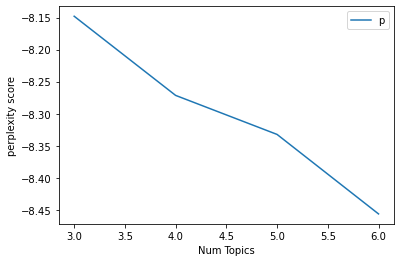

In [86]:
import matplotlib.pyplot as plt

limit=3+len(all_perplexity_score); start=3; step=1;
x = range(start, limit, step)
plt.plot(x, all_perplexity_score,label='perplexity')
plt.xlabel("Num Topics")
plt.ylabel("perplexity score")
plt.legend(("perplexity_values"), loc='best')
plt.show()

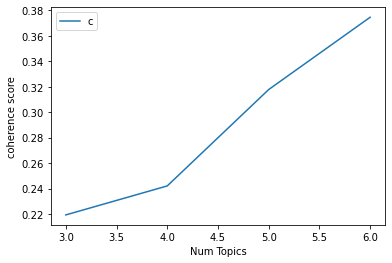

In [87]:
limit=3+len(all_perplexity_score); start=3; step=1;
x = range(start, limit, step)
plt.plot(x, all_coherence_score,label='coherence')
plt.xlabel("Num Topics")
plt.ylabel("coherence score")
plt.legend(("coherence"), loc='best')
plt.show()

In [65]:
all_lda_model_4 = gensim.models.ldamodel.LdaModel(corpus=all_corpus,
                                           id2word=all_id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [173]:
all_results_list = media_results_list + creator_results_list

In [66]:
def format_topics_sentences(ldamodel=None, corpus=all_corpus, texts=new_all_list):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=all_lda_model_4, corpus=all_corpus, texts=new_all_list)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.tail(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
4372,4372,1.0,0.3081,"piece, digital, available, want, custom, collectible, liftoff, exclusive, blockchain, mona",introducing newest innovation collection inspired rimowas iconic materials buy kind rimowa may 1...
4373,4373,3.0,0.4842,"collection, physical, digitalax, sell, owner, live, space, rarible, mint, item",congrats coachnft owners stay tuned info program future drops holders please dm us questions see...
4374,4374,0.0,0.2905,"drop, fashion, love, world, big, new, time, begin, go, pendant",congratulations
4375,4375,2.0,0.3226,"jewelry, art, make, future, think, community, auction, collector, design, cryptojeweler",anyone claim made order rogue bag given owners located us
4376,4376,0.0,0.2993,"drop, fashion, love, world, big, new, time, begin, go, pendant",worry try tomorrow next drops continue 12 24
4377,4377,0.0,0.3180,"drop, fashion, love, world, big, new, time, begin, go, pendant",try tomorrow next drops continue 12 24
4378,4378,2.0,0.3340,"jewelry, art, make, future, think, community, auction, collector, design, cryptojeweler",made order rogue bag available us owners
4379,4379,1.0,0.3005,"piece, digital, available, want, custom, collectible, liftoff, exclusive, blockchain, mona",available 12 p est get ready
4380,4380,1.0,0.3707,"piece, digital, available, want, custom, collectible, liftoff, exclusive, blockchain, mona",offering limited quantity followers free dec 17 24 available 12 p est starting tomorrow check ba...
4381,4381,3.0,0.4619,"collection, physical, digitalax, sell, owner, live, space, rarible, mint, item",entering space mark end 80th anniversary special treat celebrate holiday message give little love


In [67]:
df_dominant_topic['Dominant_Topic'].value_counts()

3.0    1905
1.0     950
0.0     895
2.0     632
Name: Dominant_Topic, dtype: int64

In [68]:
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.6124,"drop, fashion, love, world, big, new, time, begin, go, pendant",fashion exec guide outline explain key technologies projects influential fashion across digital ...
1,1.0,0.6191,"piece, digital, available, want, custom, collectible, liftoff, exclusive, blockchain, mona",2 lion crown inspired venetian coat arms incredible piece took hundreds hours create hand featur...
2,2.0,0.5390,"jewelry, art, make, future, think, community, auction, collector, design, cryptojeweler",dutch dj diablo building massive literally could stand inside literally done says diablo put pri...
3,3.0,0.7002,"collection, physical, digitalax, sell, owner, live, space, rarible, mint, item",reminder ultra careful dms discord never dm block dms common servers discord settings usefull ev...


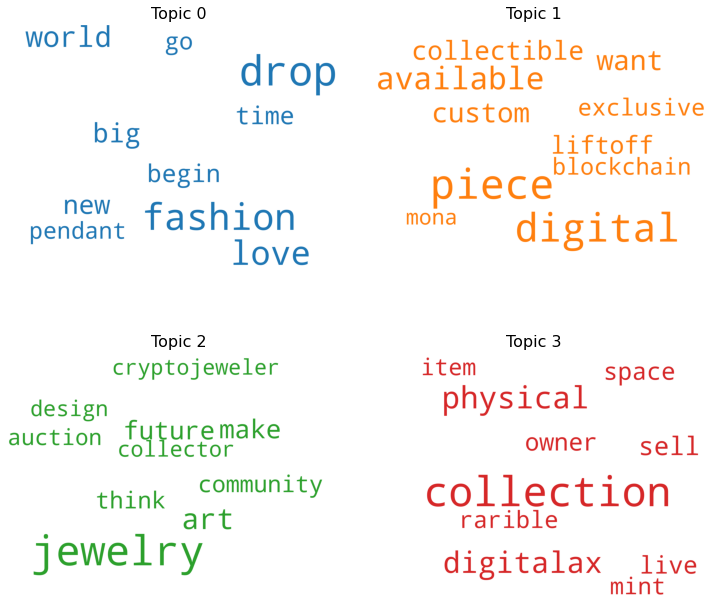

In [177]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stopwords_LDA,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=30,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = all_lda_model_4.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [178]:
sent_topics_sorteddf_mallet.to_csv('Twitter LDA CSV/topics_reptext_all.csv', index=False)
df_dominant_topic.to_csv('Twitter LDA CSV/topics_labelled_all.csv', index=False)

## ALL - 4 topic model

In [123]:
topic_1 = []
topic_1_string = ''

topic_2 = []
topic_2_string = ''

topic_3 = []
topic_3_string = ''

topic_4 = []
topic_4_string = ''

check1 = all_topics[2][0][1].split("\"")
check1 = [s.rstrip("*").lstrip(" + ") for s in check1]

check2 = all_topics[2][1][1].split("\"")
check2 = [s.rstrip("*").lstrip(" + ") for s in check2]

check3 = all_topics[2][2][1].split("\"")
check3 = [s.rstrip("*").lstrip(" + ") for s in check3]

check4 = all_topics[2][3][1].split("\"")
check4 = [s.rstrip("*").lstrip(" + ") for s in check4]

In [125]:
for i in range(15):
    topic_1.append((check1[(i*2)+1],check1[i*2]))
    topic_1_string += check1[(i*2)+1]
    topic_1_string += " "
    
    topic_2.append((check2[(i*2)+1],check2[i*2]))
    topic_2_string += check2[(i*2)+1]
    topic_2_string += " "
    
    topic_3.append((check3[(i*2)+1],check3[i*2]))
    topic_3_string += check3[(i*2)+1]
    topic_3_string += " "
    
    topic_4.append((check4[(i*2)+1],check4[i*2]))
    topic_4_string += check4[(i*2)+1]
    topic_4_string += " "

In [127]:
print("These are the words for 5 topics")
print("Perplexity score for 5-Topic model: ",all_perplexity_score[2])
print("Coherence score for 5-Topic model: ",all_coherence_score[2])
print(" ")
print("Topic 1: ",topic_1_string)
print(" ")
print("Topic 2: ",topic_2_string)
print(" ")
print("Topic 3: ",topic_3_string)
print(" ")
print("Topic 4: ",topic_4_string)
print(" ")

These are the words for 5 topics
Perplexity score for 5-Topic model:  -8.332371749132605
Coherence score for 5-Topic model:  0.31782849687151865
 
Topic 1:  digital fashion digitalax make world big time begin blockchain go digitalfashion build industry utility unlock excited find game value feature digital fashion digitalax make world big time begin blockchain go digitalfashion build industry utility unlock 
 
Topic 2:  piece available auction want sell collectible liftoff mint chain pendant real support design artist create crypto edition read purchase band piece available auction want sell collectible liftoff mint chain pendant real support design artist create 
 
Topic 3:  drop love think community cryptojeweler join hour forever change early thing collectable version happen place perfect nftcollector inspire nftcommunity gold_plate drop love think community cryptojeweler join hour forever change early thing collectable version happen place 
 
Topic 4:  jewelry collection art physic

## General, Compiler, Vogue

In [228]:
#GENERAL
general_bigram = gensim.models.Phrases(general_words, min_count=5, threshold=100)
general_trigram = gensim.models.Phrases(general_bigram[general_words], threshold=100)  

general_bigram_mod = gensim.models.phrases.Phraser(general_bigram)
general_trigram_mod = gensim.models.phrases.Phraser(general_trigram)

print(general_trigram_mod[general_bigram_mod[general_words[0]]])

['digital', 'virtual', 'spaces', 'expanding_beyond', 'games', 'roblox', 'identify', 'gaming', 'platform', 'upcoming', 'many', 'brands', 'selling', 'digital', 'physical', 'versions', 'designs', 'gucci', 'adidas', 'ar']


In [82]:
#COMPILER
compiler_bigram = gensim.models.Phrases(compiler_words, min_count=5, threshold=100)
compiler_trigram = gensim.models.Phrases(compiler_bigram[compiler_words], threshold=100)  

compiler_bigram_mod = gensim.models.phrases.Phraser(compiler_bigram)
compiler_trigram_mod = gensim.models.phrases.Phraser(compiler_trigram)

print(compiler_trigram_mod[compiler_bigram_mod[compiler_words[0]]])

['artworks', 'display', 'personal', 'space', 'loving', 'colourful', 'groovy', 'digital', 'sculptures', 'artist', 'collabs', 'potions', 'collection', 'place', 'minting']


In [96]:
#VOGUE
vogue_bigram = gensim.models.Phrases(vogue_words, min_count=5, threshold=100)
vogue_trigram = gensim.models.Phrases(vogue_bigram[vogue_words], threshold=100)  

vogue_bigram_mod = gensim.models.phrases.Phraser(vogue_bigram)
vogue_trigram_mod = gensim.models.phrases.Phraser(vogue_trigram)

print(vogue_trigram_mod[vogue_bigram_mod[vogue_words[0]]])

['man', 'features', 'designs', 'modelled', 'animated', 'characteristic', 'peace', 'collection', 'available', 'sale', 'proceeds', 'save', 'children', 'ukraine']


In [229]:
#GENERAL
def make_bigrams3(texts):
    return [general_bigram_mod[doc] for doc in texts]
def make_trigrams3(texts):
    return [general_trigram_mod[general_bigram_mod[doc]] for doc in texts]

In [83]:
#COMPILER
def make_bigrams4(texts):
    return [compiler_bigram_mod[doc] for doc in texts]
def make_trigrams4(texts):
    return [compiler_trigram_mod[compiler_bigram_mod[doc]] for doc in texts]

In [99]:
#VOGUE
def make_bigrams5(texts):
    return [vogue_bigram_mod[doc] for doc in texts]
def make_trigrams5(texts):
    return [vogue_trigram_mod[vogue_bigram_mod[doc]] for doc in texts]

In [233]:
general_bigrams = make_bigrams3(general_words)
general_lemmatized = lemmatization(general_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [84]:
compiler_bigrams = make_bigrams4(compiler_words)
compiler_lemmatized = lemmatization(compiler_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [102]:
vogue_bigrams = make_bigrams5(vogue_words)
vogue_lemmatized = lemmatization(vogue_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [234]:
# Create Dictionary
general_id2word = corpora.Dictionary(general_lemmatized)
general_texts = general_lemmatized
general_corpus = [general_id2word.doc2bow(text) for text in general_texts]

In [85]:
compiler_id2word = corpora.Dictionary(compiler_lemmatized)
compiler_texts = compiler_lemmatized
compiler_corpus = [compiler_id2word.doc2bow(text) for text in compiler_texts]

In [105]:
vogue_id2word = corpora.Dictionary(vogue_lemmatized)
vogue_texts = vogue_lemmatized
vogue_corpus = [vogue_id2word.doc2bow(text) for text in vogue_texts]

## GENERAL LDA

In [ ]:
general_topics = []
general_perplexity_score = []
general_coherence_score = []
general_vis = []

for i in range(4):
    general_lda_model = gensim.models.ldamodel.LdaModel(corpus=general_corpus,
                                           id2word=general_id2word,
                                           num_topics=i, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    
    general_topics.append(general_lda_model.show_topics(num_topics=i,num_words=30,formatted=True))
    
    general_perplexity_score.append(general_lda_model.log_perplexity(general_corpus))
    
    coherence_model_lda = CoherenceModel(model=general_lda_model, texts=general_lemmatized, dictionary=general_id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    general_coherence_score.append(coherence_lda)
    
    pyLDAvis.enable_notebook()
    vis_i = gensimvis.prepare(general_lda_model, general_corpus, general_id2word)
    general_vis.append(vis_i)

In [ ]:
general_topics

In [ ]:
general_vis[1]

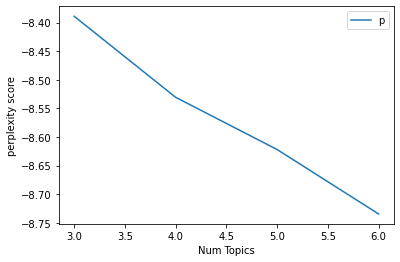

In [109]:
#general PERPLEXITY SCORE
import matplotlib.pyplot as plt

limit=3+len(general_perplexity_score); start=3; step=1;
x = range(start, limit, step)
plt.plot(x, general_perplexity_score,label='perplexity')
plt.xlabel("Num Topics")
plt.ylabel("perplexity score")
plt.legend(("perplexity_values"), loc='best')
plt.show()

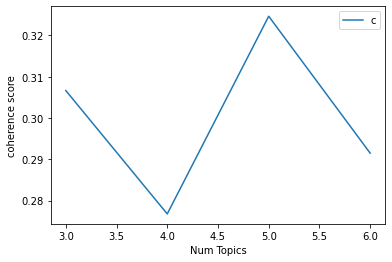

In [110]:
#general COHERENCE SCORE 
limit=3+len(general_perplexity_score); start=3; step=1;
x = range(start, limit, step)
plt.plot(x, general_coherence_score,label='coherence')
plt.xlabel("Num Topics")
plt.ylabel("coherence score")
plt.legend(("coherence"), loc='best')
plt.show()

In [235]:
general_lda_model_4 = gensim.models.ldamodel.LdaModel(corpus=general_corpus,
                                           id2word=general_id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [244]:
def format_topics_sentences_general(ldamodel=None, corpus=general_corpus, texts=new_general_list):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords_general = format_topics_sentences_general(ldamodel=general_lda_model_4, corpus=general_corpus, texts=new_general_list)

# Format
df_dominant_topic_general = df_topic_sents_keywords_general.reset_index()
df_dominant_topic_general.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic_general.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.5289,"digital, brand, new, designer, blockchain, game, virtual, future, launch, sell",digital virtual spaces expanding beyond games roblox identify gaming platform upcoming week many...
1,1,2.0,0.4445,"digital, brand, new, designer, blockchain, game, virtual, future, launch, sell",shiba inu launch new collection british designer john richmond shib shibarmy cryptocurrency cryp...
2,2,2.0,0.4439,"digital, brand, new, designer, blockchain, game, virtual, future, launch, sell",decentraland host week tommy hilfiger dolce gabbana selfridges blockchain based virtual world de...
3,3,0.0,0.4597,"art, nftcommunity, nftcollector, artist, space, nftartist, design, love, music, style",set reminder upcoming space learn speak dev team spaceshost twitterspaces womeninnfts dressmaking
4,4,1.0,0.3243,"collection, world, luxury, nftart, drop, create, industry, show, wear, sale",happening hype drop series contemporary illustrator fran ois berthoud collaboration x mad xr x f...
5,5,3.0,0.3087,"come, join, want, token, big, merch, enter, store, use, start",apien join biggest movement today 8pm est discuss ways take apiens next level makes us different...
6,6,0.0,0.3179,"art, nftcommunity, nftcollector, artist, space, nftartist, design, love, music, style",learning wearable partnerships web3
7,7,1.0,0.3554,"collection, world, luxury, nftart, drop, create, industry, show, wear, sale",retail playing role seen rebecca minkoff launching collection new york week dolce gabbana r l su...
8,8,2.0,0.3315,"digital, brand, new, designer, blockchain, game, virtual, future, launch, sell",week brands displaying accessories
9,9,0.0,0.3445,"art, nftcommunity, nftcollector, artist, space, nftartist, design, love, music, style",check photographer x collage motion artist collection


In [245]:
df_dominant_topic_general['Dominant_Topic'].value_counts()

0.0    15162
2.0     5917
1.0     3626
3.0      239
Name: Dominant_Topic, dtype: int64

In [246]:
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet_general = pd.DataFrame()
sent_topics_outdf_grpd_general = df_topic_sents_keywords_general.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd_general:
    sent_topics_sorteddf_mallet_general = pd.concat([sent_topics_sorteddf_mallet_general, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet_general.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet_general.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet_general.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.6411,"art, nftcommunity, nftcollector, artist, space, nftartist, design, love, music, style",home magazine car magazine men magazine women magazine 1 sports magazine 1 teen magazine busines...
1,1.0,0.5268,"collection, world, luxury, nftart, drop, create, industry, show, wear, sale",bored ape yacht club bored ape bape bape supreme anti social social club reference sitting every...
2,2.0,0.5931,"digital, brand, new, designer, blockchain, game, virtual, future, launch, sell",startup raising seed round 1 line digital house 3d ar assets brands investors connect startup in...
3,3.0,0.4700,"come, join, want, token, big, merch, enter, store, use, start",extinct com nesi com crowdfunds com mediar com hardway com fashions org serj com lbc co underval...


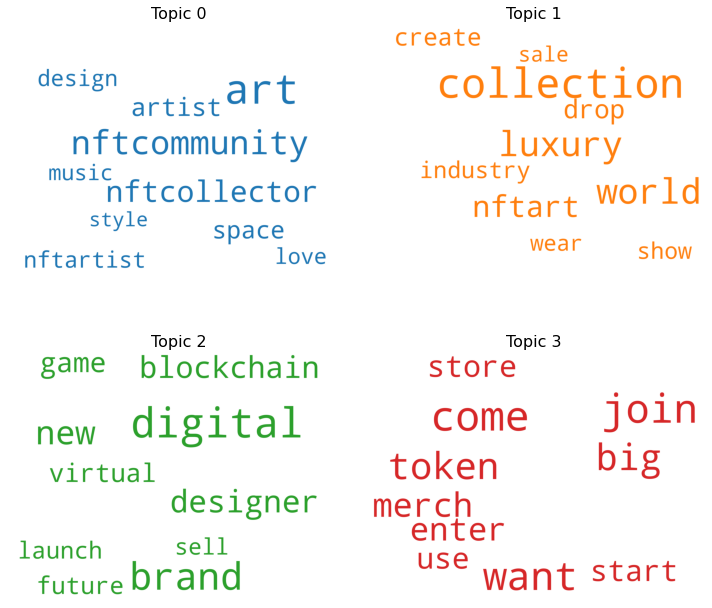

In [247]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stopwords_LDA,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=30,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = general_lda_model_4.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [248]:
sent_topics_sorteddf_mallet_general.to_csv('Twitter LDA CSV/topics_reptext_general.csv', index=False)
df_dominant_topic_general.to_csv('Twitter LDA CSV/topics_labelled_general.csv', index=False)

## GENERAL - 8 topic model

In [ ]:
# topic_1 = []
# topic_1_string = ''

# topic_2 = []
# topic_2_string = ''

# topic_3 = []
# topic_3_string = ''

# topic_4 = []
# topic_4_string = ''


# check1 = all_topics[6][0][1].split("\"")
# check1 = [s.rstrip("*").lstrip(" + ") for s in check1]

# check2 = all_topics[6][1][1].split("\"")
# check2 = [s.rstrip("*").lstrip(" + ") for s in check2]

# check3 = all_topics[6][2][1].split("\"")
# check3 = [s.rstrip("*").lstrip(" + ") for s in check3]

# check4 = all_topics[6][3][1].split("\"")
# check4 = [s.rstrip("*").lstrip(" + ") for s in check4]


In [ ]:
# for i in range(20):
#     topic_1.append((check1[(i*2)+1],check1[i*2]))
#     topic_1_string += check1[(i*2)+1]
#     topic_1_string += " "
    
#     topic_2.append((check2[(i*2)+1],check2[i*2]))
#     topic_2_string += check2[(i*2)+1]
#     topic_2_string += " "
    
#     topic_3.append((check3[(i*2)+1],check3[i*2]))
#     topic_3_string += check3[(i*2)+1]
#     topic_3_string += " "
    
#     topic_4.append((check4[(i*2)+1],check4[i*2]))
#     topic_4_string += check4[(i*2)+1]
#     topic_4_string += " "

In [ ]:
# print("These are the words for 5 topics")
# print("Perplexity score for 8-Topic model: ",general_perplexity_score[6])
# print("Coherence score for 8-Topic model: ",general_coherence_score[6])
# print(" ")
# print("Topic 1: ",topic_1_string)
# print(" ")
# print("Topic 2: ",topic_2_string)
# print(" ")
# print("Topic 3: ",topic_3_string)
# print(" ")
# print("Topic 4: ",topic_4_string)


## COMPILER LDA

In [254]:
compiler_topics = []
compiler_perplexity_score = []
compiler_coherence_score = []
compiler_vis = []

for i in range(3,5):
    compiler_lda_model = gensim.models.ldamodel.LdaModel(corpus=compiler_corpus,
                                           id2word=compiler_id2word,
                                           num_topics=i, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    
    compiler_topics.append(compiler_lda_model.show_topics(num_topics=i,num_words=30,formatted=True))
    
    compiler_perplexity_score.append(compiler_lda_model.log_perplexity(compiler_corpus))
    
    coherence_model_lda = CoherenceModel(model=compiler_lda_model, texts=compiler_lemmatized, dictionary=compiler_id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    compiler_coherence_score.append(coherence_lda)
    
    pyLDAvis.enable_notebook()
    vis_i = gensimvis.prepare(compiler_lda_model, compiler_corpus, compiler_id2word)
    compiler_vis.append(vis_i)

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [255]:
compiler_topics

[[(0,
   '0.040*"nftcommunity" + 0.035*"eye" + 0.032*"hand" + 0.032*"draw" + 0.030*"vibrant" + 0.030*"staytune" + 0.030*"inspiring" + 0.030*"unique" + 0.030*"colorful" + 0.027*"nftartist" + 0.025*"kind" + 0.023*"creation" + 0.022*"come" + 0.022*"mode" + 0.018*"nftgoddesse" + 0.018*"nftdrop" + 0.008*"inspiration" + 0.008*"work" + 0.008*"forbe" + 0.008*"chanel" + 0.008*"woman" + 0.007*"collection" + 0.006*"artist" + 0.006*"together" + 0.006*"digital" + 0.006*"big" + 0.006*"new" + 0.006*"show" + 0.006*"fashionnft" + 0.006*"shopping"'),
  (1,
   '0.027*"eye" + 0.024*"holder" + 0.017*"community" + 0.013*"artist" + 0.013*"receive" + 0.013*"much" + 0.009*"pass" + 0.009*"access" + 0.009*"art" + 0.009*"illustrator" + 0.009*"look" + 0.009*"mint" + 0.009*"welcome" + 0.009*"raffle" + 0.009*"milestone" + 0.009*"woman" + 0.009*"talias" + 0.009*"make" + 0.009*"upcoming" + 0.009*"purchase" + 0.009*"piece" + 0.009*"collection" + 0.007*"support" + 0.007*"ready" + 0.005*"nftgoddesse" + 0.005*"forbe" + 0.

In [261]:
compiler_vis[1]

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.162029 -0.082551       1        1  35.323332
2      0.051769  0.139299       2        1  33.132330
0     -0.104640 -0.006682       3        1  16.947454
1     -0.109159 -0.050065       4        1  14.596884, topic_info=             Term       Freq      Total Category  logprob  loglift
186      staytune  10.000000  10.000000  Default  30.0000  30.0000
185     inspiring  10.000000  10.000000  Default  29.0000  29.0000
187        unique  10.000000  10.000000  Default  28.0000  28.0000
177  nftcommunity  12.000000  12.000000  Default  27.0000  27.0000
205     nftartist   9.000000   9.000000  Default  26.0000  26.0000
..            ...        ...        ...      ...      ...      ...
149     worldwide   0.752652   1.937990   Topic4  -4.9970   0.9786
29         create   0.752646   6.583767   Topic4  -4.9971  -0.2444
148          week   0.752643   1.938513   Topic4  -4.9971   0.9783
107          sell   0.752640   2.073238   Topic4  -4.9971   0.9111
39       talented   0.752637   2.085250   Topic4  -4.9971   0.9053

[229 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
22        4  0.768618       absolutely
127       4  0.525408           access
128       4  0.768601          airdrop
109       2  0.679760           almost
150       2  0.574319          amazing
...     ...       ...              ...
41        2  0.701092            world
41        3  0.087637            world
225       4  0.768598  worldofwomennft
149       3  0.515999        worldwide
149       4  0.515999        worldwide

[246 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 1, 2])

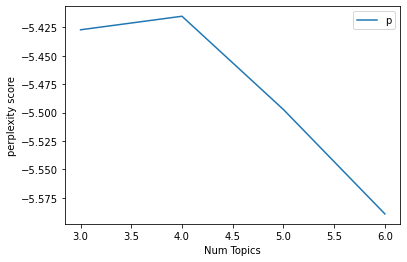

In [114]:
#compiler PERPLEXITY SCORE
import matplotlib.pyplot as plt

limit=3+len(compiler_perplexity_score); start=3; step=1;
x = range(start, limit, step)
plt.plot(x, compiler_perplexity_score,label='perplexity')
plt.xlabel("Num Topics")
plt.ylabel("perplexity score")
plt.legend(("perplexity_values"), loc='best')
plt.show()

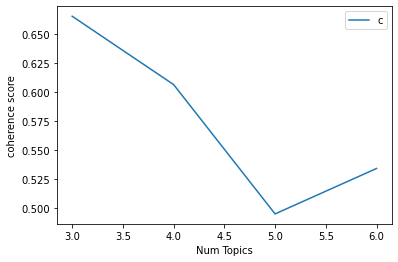

In [115]:
#compiler COHERENCE SCORE 
limit=3+len(compiler_perplexity_score); start=3; step=1;
x = range(start, limit, step)
plt.plot(x, compiler_coherence_score,label='coherence')
plt.xlabel("Num Topics")
plt.ylabel("coherence score")
plt.legend(("coherence"), loc='best')
plt.show()

In [111]:
# pyLDAvis.save_html(all_vis[6], 'all_lda_vis7.html')

In [86]:
compiler_lda_model_4 = gensim.models.ldamodel.LdaModel(corpus=compiler_corpus,
                                           id2word=compiler_id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [87]:
def format_topics_sentences_compiler(ldamodel=None, corpus=compiler_corpus, texts=compiler_results_list):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords_compiler = format_topics_sentences_compiler(ldamodel=compiler_lda_model_4, corpus=compiler_corpus, texts=compiler_results_list)

# Format
df_dominant_topic_compiler = df_topic_sents_keywords_compiler.reset_index()
df_dominant_topic_compiler.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic_compiler.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.9895,"nftcommunity, eye, hand, draw, vibrant, staytune, inspiring, unique, colorful, nftartist",fam artworks display personal space loving colourful groovy digital sculptures artist collabs po...
1,1,0.0,0.9779,"nftcommunity, eye, hand, draw, vibrant, staytune, inspiring, unique, colorful, nftartist",hi big hugs welcome fam discord waits cosy vibes
2,2,1.0,0.9693,"eye, holder, community, artist, receive, much, pass, access, art, illustrator",thank much absolutely art empowerment women education
3,3,2.0,0.9914,"world, trait, eye, draw, vibrant, hand, colorful, industry, contrast, belittle",hi hannah love come explore world art luxury vibrant cosmopolitan art talented artist mission cr...
4,4,1.0,0.9895,"eye, holder, community, artist, receive, much, pass, access, art, illustrator",working way roadmap milestone giveaways reward holders women led projects raffle 1 random holder...
5,5,2.0,0.9909,"world, trait, eye, draw, vibrant, hand, colorful, industry, contrast, belittle",collection 8 888 fine art 250 hand drawn vibrant traits created inspired contrast colorful fun w...
6,6,0.0,0.9779,"nftcommunity, eye, hand, draw, vibrant, staytune, inspiring, unique, colorful, nftartist",like may focused using style identifier rather physical attributes
7,7,0.0,0.6548,"nftcommunity, eye, hand, draw, vibrant, staytune, inspiring, unique, colorful, nftartist",know know women led collection 8 888 illustrations 250 hand drawn traits illustrator focused ide...
8,8,2.0,0.9898,"world, trait, eye, draw, vibrant, hand, colorful, industry, contrast, belittle",8 888 piece collection 250 hand drawn vibrant traits capturing best luxury public minting begins...
9,9,2.0,0.9925,"world, trait, eye, draw, vibrant, hand, colorful, industry, contrast, belittle",wed love support 8 888 piece collection 250 hand drawn vibrant traits inspired contrast colorful...


In [88]:
df_dominant_topic_compiler['Dominant_Topic'].value_counts()

0.0    24
2.0    19
1.0    15
Name: Dominant_Topic, dtype: int64

In [89]:
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet_compiler = pd.DataFrame()
sent_topics_outdf_grpd_compiler = df_topic_sents_keywords_compiler.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd_compiler:
    sent_topics_sorteddf_mallet_compiler = pd.concat([sent_topics_sorteddf_mallet_compiler, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet_compiler.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet_compiler.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet_compiler.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9901,"nftcommunity, eye, hand, draw, vibrant, staytune, inspiring, unique, colorful, nftartist",staytuned kind 10k unique hand drawn colorful vibrant inspiring eyes forbes 30 30 worked chanel ...
1,1.0,0.9895,"eye, holder, community, artist, receive, much, pass, access, art, illustrator",working way roadmap milestone giveaways reward holders women led projects raffle 1 random holder...
2,2.0,0.9925,"world, trait, eye, draw, vibrant, hand, colorful, industry, contrast, belittle",wed love support 8 888 piece collection 250 hand drawn vibrant traits inspired contrast colorful...


IndexError: list index out of range

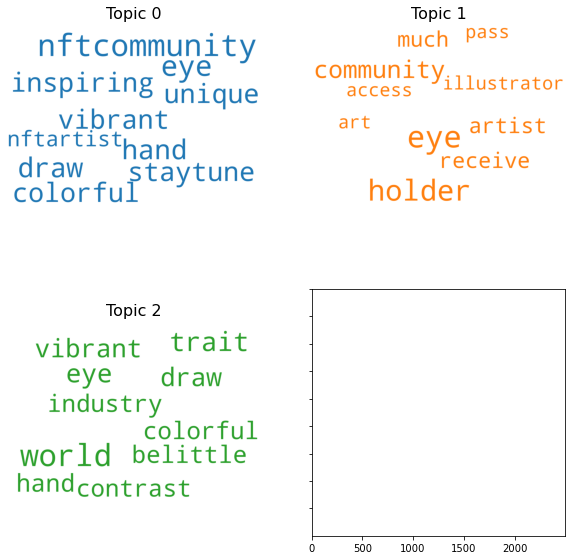

In [42]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stopwords_LDA,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=30,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = compiler_lda_model_4.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [43]:
sent_topics_sorteddf_mallet_compiler.to_csv('Twitter LDA CSV/topics_reptext_compiler.csv', index=False)
df_dominant_topic_compiler.to_csv('Twitter LDA CSV/topics_labelled_compiler.csv', index=False)

## VOGUE LDA

In [116]:
vogue_topics = []
vogue_perplexity_score = []
vogue_coherence_score = []
vogue_vis = []

for i in range(3,11):
    vogue_lda_model = gensim.models.ldamodel.LdaModel(corpus=vogue_corpus,
                                           id2word=vogue_id2word,
                                           num_topics=i, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    
    vogue_topics.append(vogue_lda_model.show_topics(num_topics=i,num_words=20))
    
    vogue_perplexity_score.append(vogue_lda_model.log_perplexity(vogue_corpus))
    
    coherence_model_lda = CoherenceModel(model=vogue_lda_model, texts=vogue_lemmatized, dictionary=vogue_id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    vogue_coherence_score.append(coherence_lda)
    
    pyLDAvis.enable_notebook()
    vis_i = gensimvis.prepare(vogue_lda_model, vogue_corpus, vogue_id2word)
    vogue_vis.append(vis_i)

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [117]:
vogue_topics

[[(0,
   '0.041*"ukraine" + 0.041*"collection" + 0.033*"save" + 0.033*"sale" + 0.033*"child" + 0.033*"proceed" + 0.031*"live" + 0.031*"peace" + 0.021*"available" + 0.020*"vogue" + 0.017*"sgt" + 0.017*"go" + 0.015*"design" + 0.009*"depict" + 0.009*"beauty" + 0.009*"cover" + 0.009*"auction" + 0.009*"chance" + 0.009*"vase" + 0.006*"issue"'),
  (1,
   '0.035*"artist" + 0.020*"join" + 0.017*"chat" + 0.017*"voguenftissue" + 0.016*"voguesingapore" + 0.013*"vogue" + 0.012*"designer" + 0.009*"sgt" + 0.009*"voguenftcollection" + 0.009*"super" + 0.009*"utc" + 0.009*"win" + 0.009*"pm" + 0.009*"host" + 0.009*"look" + 0.009*"question" + 0.009*"art" + 0.009*"think" + 0.009*"photographer" + 0.009*"top"'),
  (2,
   '0.033*"vogue" + 0.029*"dress" + 0.017*"box" + 0.014*"flame" + 0.014*"virtual" + 0.014*"mystery" + 0.014*"drop" + 0.013*"available" + 0.011*"artwork" + 0.011*"video" + 0.011*"month" + 0.008*"collection" + 0.008*"x" + 0.007*"sgt" + 0.007*"partnership" + 0.007*"cover" + 0.007*"pm" + 0.007*"gam

In [143]:
vogue_vis[2]

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.181390 -0.009978       1        1  46.806936
2      0.067360 -0.127388       2        1  19.450216
1      0.075167  0.066745       3        1  15.919637
0      0.026956  0.060667       4        1   9.910603
3      0.011907  0.009954       5        1   7.912607, topic_info=           Term       Freq      Total Category  logprob  loglift
13      ukraine  13.000000  13.000000  Default  30.0000  30.0000
239         box   5.000000   5.000000  Default  29.0000  29.0000
50         join   4.000000   4.000000  Default  28.0000  28.0000
57         live   9.000000   9.000000  Default  27.0000  27.0000
4    collection  13.000000  13.000000  Default  26.0000  26.0000
..          ...        ...        ...      ...      ...      ...
48      founder   0.550699   2.585226   Topic5  -4.5244   0.9903
136       cover   0.550695   3.951547   Topic5  -4.5244   0.5660
147       video   0.550695   2.436932   Topic5  -4.5245   1.0494
229        take   0.550691   1.759632   Topic5  -4.5245   1.3750
161     auction   0.550690   3.063243   Topic5  -4.5245   0.8207

[253 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
196       3  0.797363      75bnb
92        4  0.876197   absolute
97        5  0.923913     advice
119       1  0.874087     answer
21        1  0.961395  antarctic
...     ...       ...        ...
91        3  0.797367     winter
96        4  0.876197    witness
271       3  0.797363      worth
64        1  0.549045          x
64        2  0.274522          x

[265 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 2, 1, 4])

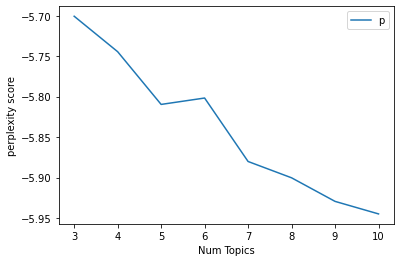

In [119]:
#vogue PERPLEXITY SCORE
import matplotlib.pyplot as plt

limit=3+len(vogue_perplexity_score); start=3; step=1;
x = range(start, limit, step)
plt.plot(x, vogue_perplexity_score,label='perplexity')
plt.xlabel("Num Topics")
plt.ylabel("perplexity score")
plt.legend(("perplexity_values"), loc='best')
plt.show()

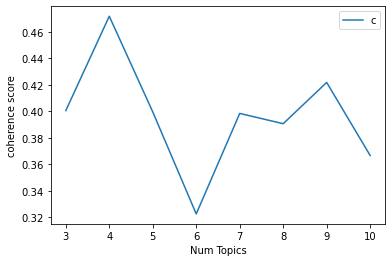

In [120]:
#vogue COHERENCE SCORE 
limit=3+len(vogue_perplexity_score); start=3; step=1;
x = range(start, limit, step)
plt.plot(x, vogue_coherence_score,label='coherence')
plt.xlabel("Num Topics")
plt.ylabel("coherence score")
plt.legend(("coherence"), loc='best')
plt.show()

In [ ]:
# pyLDAvis.save_html(all_vis[6], 'all_lda_vis7.html')

In [144]:
vogue_lda_model_5 = gensim.models.ldamodel.LdaModel(corpus=vogue_corpus,
                                           id2word=vogue_id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [149]:
def format_topics_sentences_vogue(ldamodel=None, corpus=vogue_corpus, texts=vogue_results_list):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords_vogue = format_topics_sentences_vogue(ldamodel=vogue_lda_model_5, corpus=vogue_corpus, texts=vogue_results_list)

# Format
df_dominant_topic_vogue = df_topic_sents_keywords_vogue.reset_index()
df_dominant_topic_vogue.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic_vogue.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.9846,"ukraine, collection, sale, child, proceed, peace, save, live, vogue, artist",man features designs modelled animated characteristic part peace collection available sale proce...
1,1,4.0,0.9856,"ukraine, collection, sale, child, proceed, peace, save, live, vogue, artist",saint george defeats russian warship guniaproject depicts saint george slayer represent victory ...
2,2,4.0,0.9879,"ukraine, collection, sale, child, proceed, peace, save, live, vogue, artist",antarctic expedition sees ukraine antarctic team wearing ienki ienki expedition parkas part peac...
3,3,4.0,0.6651,"ukraine, collection, sale, child, proceed, peace, save, live, vogue, artist",x intergalactic freedom dress peace collection sees tulle dress navy gold inspired ukrainian fla...
4,4,4.0,0.9872,"ukraine, collection, sale, child, proceed, peace, save, live, vogue, artist",ukrainian culture poppy symbol beauty youth goes along dna brand shares poppy peace collection p...
5,5,4.0,0.6424,"ukraine, collection, sale, child, proceed, peace, save, live, vogue, artist",happening soon looking forward chatting eic designers founders peace many joining chat ukraine v...
6,6,4.0,0.9879,"ukraine, collection, sale, child, proceed, peace, save, live, vogue, artist",gunia projects artworks depict war molotov cocktails anti tank missiles part x peace collection ...
7,7,4.0,0.9821,"ukraine, collection, sale, child, proceed, peace, save, live, vogue, artist",design modelled character part x peace collection sale live proceeds go save children ukraine
8,8,4.0,0.9834,"ukraine, collection, sale, child, proceed, peace, save, live, vogue, artist",intergalactic freedom dress x peace collection sale goes live 15 march 8pm sgt proceeds go save ...
9,9,4.0,0.9872,"ukraine, collection, sale, child, proceed, peace, save, live, vogue, artist",photo ukraine antarctic team wearing ienki ienki designs part x peace collection sale goes live ...


In [150]:
df_dominant_topic_vogue['Dominant_Topic'].value_counts()

4.0    26
2.0    10
1.0     9
0.0     6
3.0     4
Name: Dominant_Topic, dtype: int64

In [151]:
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet_vogue = pd.DataFrame()
sent_topics_outdf_grpd_vogue = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd_vogue:
    sent_topics_sorteddf_mallet_vogue = pd.concat([sent_topics_sorteddf_mallet_vogue, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet_vogue.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet_vogue.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet_vogue.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9845,"issue, create, cover, available, vogue, design, live, vase, historic, voguenftissue",italian design duo lanzavecchia wai created digitally rendered vase made blooms aptly named livi...
1,1.0,0.9833,"join, chat, voguesingapore, artist, super, voguenftcollection, win, voguenftissue, art, technology",3 3 obtain 3 super super rare city cards vogue mystery box youll chance join lucky draw win 1 3 ...
2,2.0,0.9872,"vogue, box, mystery, dress, artwork, flame, city, pm, video, series",congrats 2 winners vogue mystery box lucky draw youll receive timepiece swiss independent luxury...
3,3.0,0.9833,"collection, vogue, available, voguesingapore, think, founder, long, include, trunk, iconic",paying tribute legendary founder global months long spectacle includes iconic trunk reimagined c...
4,4.0,0.9879,"ukraine, collection, sale, child, proceed, peace, save, live, vogue, artist",antarctic expedition sees ukraine antarctic team wearing ienki ienki expedition parkas part peac...


In [153]:
sent_topics_sorteddf_mallet_vogue.to_csv('Twitter LDA CSV/topics_reptext_vogue.csv', index=False)
df_dominant_topic_vogue.to_csv('Twitter LDA CSV/topics_labelled_vogue.csv', index=False)

IndexError: list index out of range

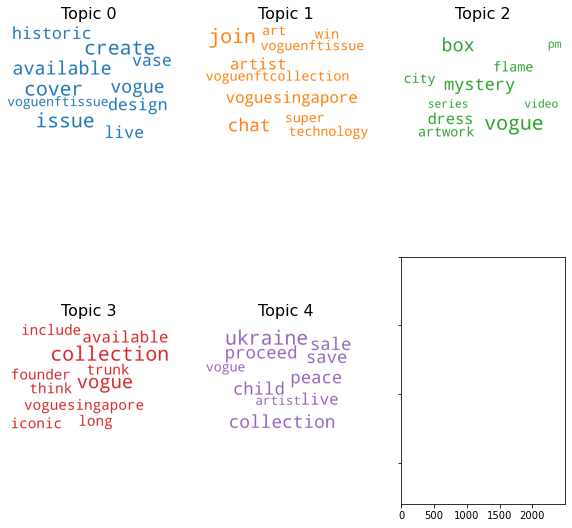

In [156]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stopwords_LDA,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=30,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = vogue_lda_model_5.show_topics(formatted=False)

fig, axes = plt.subplots(2,3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## MEDIA, CREATOR PROCESSING

In [ ]:
# #MEDIA
# media_bigram = gensim.models.Phrases(media_words, min_count=5, threshold=100)
# media_trigram = gensim.models.Phrases(media_bigram[media_words], threshold=100)  

# media_bigram_mod = gensim.models.phrases.Phraser(media_bigram)
# media_trigram_mod = gensim.models.phrases.Phraser(media_trigram)

# print(media_trigram_mod[media_bigram_mod[media_words[0]]])

# #CREATOR
# creator_bigram = gensim.models.Phrases(creator_words, min_count=5, threshold=100)
# creator_trigram = gensim.models.Phrases(creator_bigram[creator_words], threshold=100)  

# creator_bigram_mod = gensim.models.phrases.Phraser(creator_bigram)
# creator_trigram_mod = gensim.models.phrases.Phraser(creator_trigram)

# print(creator_trigram_mod[creator_bigram_mod[creator_words[0]]])

In [ ]:
# #MEDIA
# def make_bigrams1(texts):
#     return [media_bigram_mod[doc] for doc in texts]
# def make_trigrams1(texts):
#     return [media_trigram_mod[media_bigram_mod[doc]] for doc in texts]

# #CREATOR
# def make_bigrams2(texts):
#     return [creator_bigram_mod[doc] for doc in texts]
# def make_trigrams2(texts):
#     return [creator_trigram_mod[creator_bigram_mod[doc]] for doc in texts]

In [ ]:
# #BIGRAMS
# media_bigrams = make_bigrams1(media_words)
# media_lemmatized = lemmatization(media_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# creator_bigrams = make_bigrams2(creator_words)
# creator_lemmatized = lemmatization(creator_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# print(media_lemmatized[:1])

In [ ]:
# media_id2word = corpora.Dictionary(media_lemmatized)
# creator_id2word = corpora.Dictionary(creator_lemmatized)

# media_texts = media_lemmatized
# creator_texts = creator_lemmatized

# media_corpus = [media_id2word.doc2bow(text) for text in media_texts]
# creator_corpus = [creator_id2word.doc2bow(text) for text in creator_texts]

## MEDIA LDA

In [ ]:
# media_topics = []
# media_perplexity_score = []
# media_coherence_score = []
# media_vis = []

# for i in range(3,11):
#     media_lda_model = gensim.models.ldamodel.LdaModel(corpus=media_corpus,
#                                            id2word=media_id2word,
#                                            num_topics=i, 
#                                            random_state=100,
#                                            update_every=1,
#                                            chunksize=100,
#                                            passes=10,
#                                            alpha='auto',
#                                            per_word_topics=True)
    
#     media_topics.append(media_lda_model.show_topics(num_topics=i,num_words=30,formatted=True))
    
#     media_perplexity_score.append(media_lda_model.log_perplexity(media_corpus))
    
#     coherence_model_lda = CoherenceModel(model=media_lda_model, texts=media_lemmatized, dictionary=media_id2word, coherence='c_v')
#     coherence_lda = coherence_model_lda.get_coherence()
#     media_coherence_score.append(coherence_lda)
    
#     pyLDAvis.enable_notebook()
#     vis_i = gensimvis.prepare(media_lda_model, media_corpus, media_id2word)
#     media_vis.append(vis_i)

In [ ]:
# media_topics

In [ ]:
# media_vis[0]

In [ ]:
# #MEDIA PERPLEXITY SCORE
# import matplotlib.pyplot as plt

# limit=3+len(media_perplexity_score); start=3; step=1;
# x = range(start, limit, step)
# plt.plot(x, media_perplexity_score,label='perplexity')
# plt.xlabel("Num Topics")
# plt.ylabel("perplexity score")
# plt.legend(("perplexity_values"), loc='best')
# plt.show()

In [ ]:
# # MEDIA COHERENCE SCORE 
# limit=3+len(media_perplexity_score); start=3; step=1;
# x = range(start, limit, step)
# plt.plot(x, media_coherence_score,label='coherence')
# plt.xlabel("Num Topics")
# plt.ylabel("coherence score")
# plt.legend(("coherence"), loc='best')
# plt.show()

## CREATOR LDA

In [ ]:
# creator_topics = []
# creator_perplexity_score = []
# creator_coherence_score = []
# creator_vis = []

# for i in range(3,11):
#     creator_lda_model = gensim.models.ldamodel.LdaModel(corpus=creator_corpus,
#                                            id2word=creator_id2word,
#                                            num_topics=i, 
#                                            random_state=100,
#                                            update_every=1,
#                                            chunksize=100,
#                                            passes=10,
#                                            alpha='auto',
#                                            per_word_topics=True)
    
#     creator_topics.append(creator_lda_model.show_topics(num_topics=i,num_words=30,formatted=True))
    
#     creator_perplexity_score.append(creator_lda_model.log_perplexity(creator_corpus))
    
#     coherence_model_lda = CoherenceModel(model=creator_lda_model, texts=creator_lemmatized, dictionary=creator_id2word, coherence='c_v')
#     coherence_lda = coherence_model_lda.get_coherence()
#     creator_coherence_score.append(coherence_lda)
    
#     pyLDAvis.enable_notebook()
#     vis_i = gensimvis.prepare(creator_lda_model, creator_corpus, creator_id2word)
#     creator_vis.append(vis_i)

In [ ]:
# creator_topics

In [ ]:
# creator_vis[0]

In [ ]:
# #CREATOR PERPLEXITY SCORE
# import matplotlib.pyplot as plt

# limit=3+len(creator_perplexity_score); start=3; step=1;
# x = range(start, limit, step)
# plt.plot(x, creator_perplexity_score,label='perplexity')
# plt.xlabel("Num Topics")
# plt.ylabel("perplexity score")
# plt.legend(("perplexity_values"), loc='best')
# plt.show()

In [ ]:
# #CREATOR COHERENCE SCORE 
# limit=3+len(creator_perplexity_score); start=3; step=1;
# x = range(start, limit, step)
# plt.plot(x, creator_coherence_score,label='coherence')
# plt.xlabel("Num Topics")
# plt.ylabel("coherence score")
# plt.legend(("coherence"), loc='best')
# plt.show()